In [1]:
import torch
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from models.ConditionalUNet1D import ConditionalUnet1D
from utils.tools import SO3_to_ortho6d, ortho6d_to_SO3, create_se3_matrix
import os, pickle
import numpy as np
from utils.core import compute_jacobian, compute_PMP, compute_rank
import matplotlib.pyplot as plt


In [2]:
model = "DDPM"
model_path = "./params/pouring_dataset_augmented/" + model + "/model_ep2499.pt"
dataset_path = "./datasets/pouring_data/"
data_name = "3_water_200.pkl"
device = 'cuda'
num_diffusion_iters = 100
input_dim=9

In [3]:
# Load data
with open(os.path.join(dataset_path, data_name), 'rb') as f:
    data = pickle.load(f)

# Trajectory of bottle
traj = data['traj']
traj = traj@np.array([[
    [1., 0., 0., data['offset'][0]], 
    [0., 1., 0., data['offset'][1]], 
    [0., 0., 1., data['offset'][2]], 
    [0., 0., 0., 1.]]])

traj = torch.Tensor(traj).type(torch.float32).to(device)

rotation_matrices = traj[:, :3, :3]
translations = traj[:, :3, 3]

ortho6d = SO3_to_ortho6d(rotation_matrices)
traj = torch.cat([ortho6d, translations], dim=1)
traj = torch.unsqueeze(traj, 0)

print("traj.shape:",traj.shape)

traj.shape: torch.Size([1, 480, 9])


In [4]:
# Load model
noise_pred_net = ConditionalUnet1D(
    input_dim=input_dim,
    global_cond_dim=0
)

noise_pred_net = torch.load(model_path, map_location='cuda', weights_only=False)

if model == "DDPM":
    noise_scheduler = DDPMScheduler(
        num_train_timesteps=num_diffusion_iters,
        beta_schedule='linear',
        clip_sample=True,
        prediction_type='epsilon'
    )
elif model == "DDIM":
    noise_scheduler = DDIMScheduler(
        num_train_timesteps=num_diffusion_iters,
        beta_schedule='linear',
        clip_sample=True,
        prediction_type='epsilon'
    )

_ = noise_pred_net.to(device)

In [5]:
jacobian_rank = []
for t in [x * 0.05 for x in range(20)]:
    timestep = int(t * num_diffusion_iters)

    # Calculate x_t
    noise = torch.randn(traj.shape, device=device)
    x_t = noise_scheduler.add_noise(
        traj, noise, torch.tensor([timestep], dtype=torch.long).to(device)
    )

    # Compute Jacobian of PMP with respect to x_t
    x_t = x_t.requires_grad_(True)

    jacobian = compute_jacobian(lambda x: compute_PMP(x, timestep, noise_pred_net, noise_scheduler), x_t)
    
    if t==0:
        print("Jacobian shape:", jacobian.shape)
    
    batch_size, jacobian_dim, _, _, _ = jacobian.shape
    jacobian_reshaped = jacobian.view(jacobian_dim,jacobian_dim)

    # Compute the rank of the Jacobian matrix
    jacobian_rank.append(compute_rank(jacobian_reshaped))

Jacobian shape: torch.Size([1, 4320, 1, 480, 9])


In [6]:
jacobian_rank_ratio = [a/jacobian_reshaped.shape[0] for a in jacobian_rank]

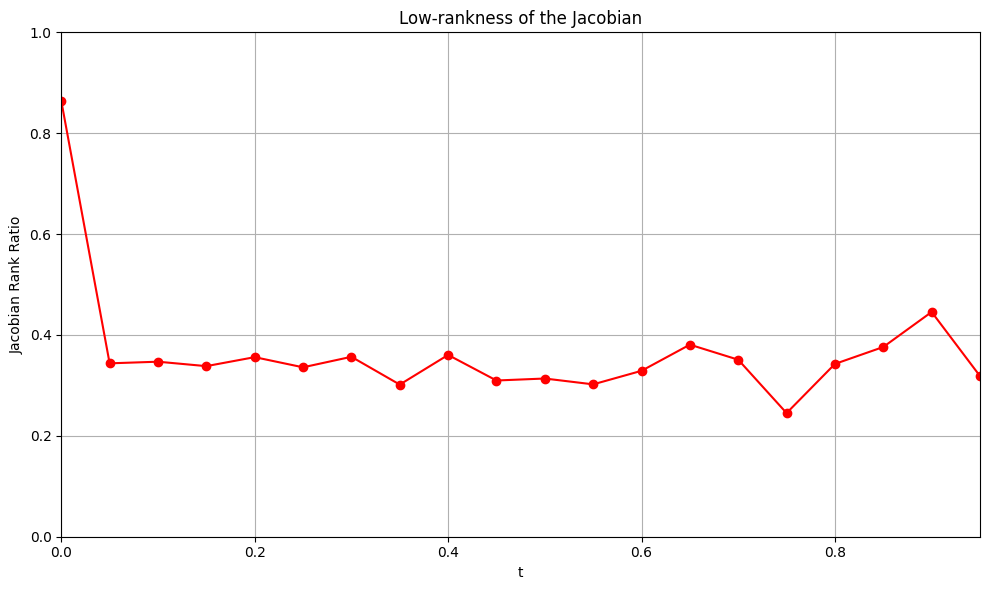

In [7]:
x = np.arange(0, 1, 1 / len(jacobian_rank_ratio))
plt.figure(figsize=(10, 6))
plt.plot(x, jacobian_rank_ratio, marker='o', linestyle='-', color='r')
plt.xlabel('t')
plt.ylabel('Jacobian Rank Ratio')
plt.title('Low-rankness of the Jacobian')
plt.xlim(0, 1 - 1 / len(jacobian_rank_ratio))
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(jacobian_rank)